In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
matplotlib.rc('font', **font)

import sqlite3
import pandas as pd
import datetime as dt
from src import clean_data as d
conn = sqlite3.connect('data/billboard-200.db')

In [2]:
albums_table, albums, artists, songs = d.get()
song_parameters = d.song_parameters
normal_parameters = d.normal_parameters

In [3]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

def vibe(chart, params = song_parameters):
        return {p:weighted_score(p, chart) for p in params}

# Vibe of Popular Music Over Time

In [4]:
weekly_charts = albums_table.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')

week_dates = [date for date in weekly_charts.groups.keys()]
week_scores = [vibe(chart) for _, chart in weekly_charts]

# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

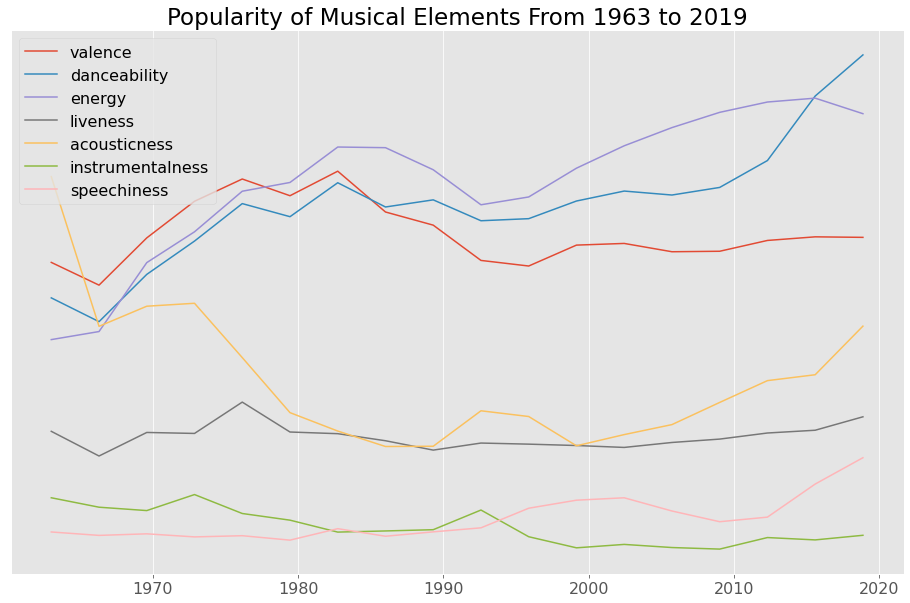

In [5]:
# Resample timeseries by every 1200 days to smooth out noise
delta = dt.timedelta(days=1200)
resampled = parameter_ts.resample(delta).mean()

fig, ax = plt.subplots(figsize=(16,10))
for p in normal_parameters:
    ax.plot(resampled.index, resampled[p])

ax.set_title('Popularity of Musical Elements From 1963 to 2019')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters)

fig.savefig('images/vibe_full_timeseries.png');

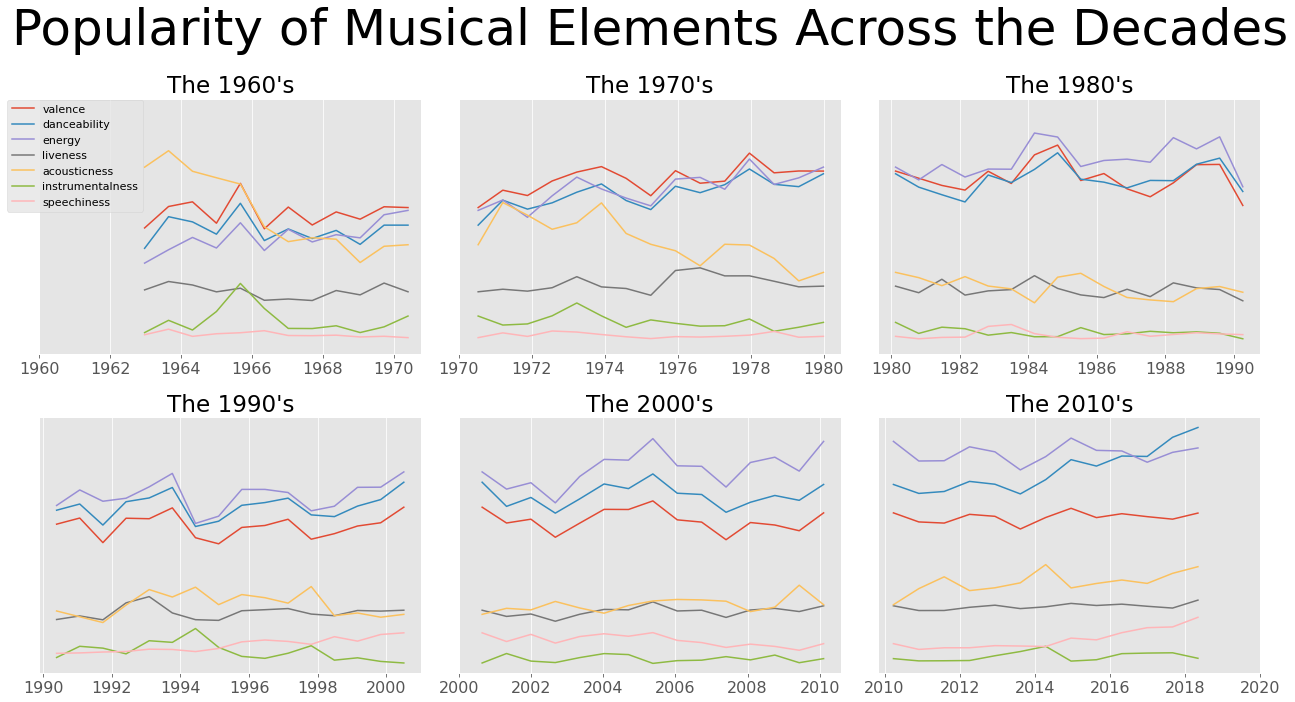

In [6]:
delta = dt.timedelta(days=250)
resampled = parameter_ts.resample(delta).mean()

sixties       = resampled.loc['1960':'1970']
seventies     = resampled.loc['1970':'1980-02-15'] #hotfix
eighties      = resampled.loc['1980':'1990']
nineties      = resampled.loc['1990':'2000']
two_thousands = resampled.loc['2000':'2010-03-29'] #
twenty_tens   = resampled.loc['2010':'2020']

decade_ts = [sixties,
            seventies,
            eighties,
            nineties,
            two_thousands,
            twenty_tens]

decade_names = ["1960's",
                "1970's",
                "1980's",
                "1990's",
                "2000's",
                "2010's"]

timestamps = [dt.date(1960, 1, 1),
              dt.date(1970, 1, 1),
              dt.date(1980, 1, 1),
              dt.date(1990, 1, 1),
              dt.date(2000, 1, 1),
              dt.date(2010, 1, 1)]

fig, ax = plt.subplots(2, 3, figsize=(18,10))
for a, name, ts, timestamp in zip(ax.flatten(), decade_names, decade_ts, timestamps):
    for p in normal_parameters:
        a.plot(ts.index, ts[p])

    a.set_title(f'The {name}')
    a.set_ylabel('Popularity')
    a.set_ylim(0, .65)
    a.get_yaxis().set_visible(False)
    
    years = [timestamp + i*dt.timedelta(days=370) for i in range(0, 11, 2)]
    a.set_xticks(years)
    a.set_xticklabels([year.year for year in years])
    
# ax[0,0].legend(normal_parameters, fontsize=12)
fig.legend(normal_parameters, fontsize=11, loc='upper left', bbox_to_anchor=(0., 0.858))
fig.suptitle('Popularity of Musical Elements Across the Decades', fontsize=50)
fig.tight_layout()

fig.savefig('images/vibe_by_decade.png')